In [124]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch

Make sure to download the 'boston-utility-data.csv' file from the Google Drive link and place it into a folder called 'data'.

In [125]:
df = pd.read_csv('data/boston-utility-data.csv')
df.head(3)

,InvoiceID,AccountNumber,EnergyTypeName,InvoiceDate,FromDate,ToDate,UsagePeriodDays,DeliveryCost,SupplyCost,TotalCost,...,City,Zip,StateName,Abbreviation,CountryName,SiteName,Currency,CodeDescription,DepartmentName,_ingest_datetime
0,6602853,73004104763,Natural Gas,2015-09-10,2015-08-11,2015-09-10,30,104.18,0.0,104.18,...,Boston,02136,Massachusetts,MA,United States,Hyde Park HS,USD,Delivery Invoice,BPS,2024-11-01 14:10:59+00
1,6589679,9504656628,Steam,2014-01-29,2014-01-02,2014-01-29,27,5437.78,0.0,5437.78,...,Boston,02108,Massachusetts,MA,United States,Unknown,USD,Delivery Invoice,PMD,2024-11-01 14:10:59+00
2,6610018,73004109036,Natural Gas,2011-08-31,2011-08-01,2011-08-31,30,31.71,0.0,31.71,...,Boston,02136,Massachusetts,MA,United States,Chittick,USD,Delivery Invoice,BPS,2024-11-01 14:10:59+00


In [126]:
df = df.drop(columns=['InvoiceID', 'AccountNumber', 'FromDate', 'ToDate', 'StreetAddress', 'City', 'Zip', 'StateName', 'Abbreviation', 'CountryName', 'SiteName', 'Currency', 'CodeDescription', '_ingest_datetime'])

In [127]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['InvoiceDate'].dt.year >= 2011]
df = df.dropna(subset=['InvoiceDate'])
df = df.dropna(subset=['DepartmentName'])

print("Data range after filtering:")
print(f"Start Date: {df['InvoiceDate'].min()}")
print(f"End Date: {df['InvoiceDate'].max()}")

Data range after filtering:
Start Date: 2011-01-02 00:00:00
End Date: 2024-10-26 00:00:00


In [130]:
print(df['DepartmentName'].unique())
df.info()

['BPS' 'PMD' 'BTD' 'PARKS' 'BFD' 'BCYF' 'PWD' 'DND' 'BPL' 'BPD' 'COB'
 'MOH' 'PARK' 'PARKS ' 'BPHC' ' BPS' ' PARKS' 'UNKNOWN' 'Parks'
 'PROP MGMT' 'A' 'City of Boston ' 'Park' ' PWD' 'Parcels 03711002'
 '?Parks' '?DND' 'PARKK' 'Arts&Culture' 'Arts& Culture' 'ISD' 'Prop Mgmt'
 'SCH' 'áBTD' '\xa0BTD' 'CON' 'COb Parks' 'COB PMD' 'MOH ' 'Parks '
 'BPHC ' 'BPHS' 'BPSC']
<class 'pandas.core.frame.DataFrame'>
Index: 725157 entries, 0 to 734837
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   EnergyTypeName    725157 non-null  object        
 1   InvoiceDate       725157 non-null  datetime64[ns]
 2   UsagePeriodDays   725157 non-null  int64         
 3   DeliveryCost      725157 non-null  float64       
 4   SupplyCost        725157 non-null  float64       
 5   TotalCost         725157 non-null  float64       
 6   TotalConsumption  724477 non-null  float64       
 7   DemandkW          724477 n

In [116]:
department_mapping = {
    'BPS': 'Boston Public Schools',
    ' BPS': 'Boston Public Schools',
    'SCH': 'Boston Public Schools',
    'BPSC': 'Boston Public Schools',

    'PMD': 'Property Management Department',
    'PROP MGMT': 'Property Management Department',
    'Prop Mgmt': 'Property Management Department',
    'COB PMD': 'Property Management Department',

    'BTD': 'Boston Transportation',
    'áBTD': 'Boston Transportation',
    '\xa0BTD': 'Boston Transportation',

    'PARKS': 'Boston Parks and Recreation',
    'PARK': 'Boston Parks and Recreation',
    'PARKS ': 'Boston Parks and Recreation',
    ' PARKS': 'Boston Parks and Recreation',
    'Parks': 'Boston Parks and Recreation',
    'Park': 'Boston Parks and Recreation',
    '?Parks': 'Boston Parks and Recreation',
    'PARKK': 'Boston Parks and Recreation',
    'COb Parks': 'Boston Parks and Recreation',
    'Parks ': 'Boston Parks and Recreation',

    'BFD': 'Boston Fire Department',
    'BCYF': 'Boston Centers for Youth and Families',
    
    'PWD': 'Public Works Department',
    ' PWD': 'Public Works Department',
    
    'DND': 'Department of Neighborhood Development',
    '?DND': 'Department of Neighborhood Development',
    
    'BPL': 'Boston Public Library',
    'BPD': 'Boston Police Department',

    'COB': 'City of Boston',
    'City of Boston ': 'City of Boston',
    
    'MOH': "Mayor's Office of Housing",
    'MOH ': "Mayor's Office of Housing",
    
    'BPHC': 'Boston Public Health Commission',
    'BPHC ': 'Boston Public Health Commission', 
    'BPHS': 'Boston Public Health Commission',

    'Arts&Culture': 'Arts and Culture', 
    'Arts& Culture': 'Arts and Culture',
    
    'ISD': 'Inspectional Services Department',
    'CON': 'Conservation and Recreation'
}

In [131]:
df['DepartmentName'] = df['DepartmentName'].map(department_mapping).fillna('UNKNOWN')
print(df['DepartmentName'].unique())

['Boston Public Schools' 'Property Management Department'
 'Boston Transportation' 'Boston Parks and Recreation'
 'Boston Fire Department' 'Boston Centers for Youth and Families'
 'Public Works Department' 'Department of Neighborhood Development'
 'Boston Public Library' 'Boston Police Department' 'City of Boston'
 "Mayor's Office of Housing" 'Boston Public Health Commission' 'UNKNOWN'
 'Arts and Culture' 'Inspectional Services Department'
 'Conservation and Recreation']


In [132]:
df_grouped = df.groupby([pd.Grouper(key='InvoiceDate', freq='ME'), 'DepartmentName'])['TotalCost'].sum().reset_index()
df_pivot = df_grouped.pivot(index='InvoiceDate', columns='DepartmentName', values='TotalCost')

In [135]:
# 3.1: Inspect Data Types
print("\nData Types in df_grouped:")
print(df_grouped.dtypes)

print("\nData Types in df_pivot:")
print(df_pivot.dtypes)

# Convert 'DepartmentName' to category if not already
if df_grouped['DepartmentName'].dtype != 'category':
    df_grouped['DepartmentName'] = df_grouped['DepartmentName'].astype('category')

# 3.2: Check for Missing Values
print("\nMissing Values in df_grouped:")
print(df_grouped.isnull().sum())

print("\nMissing Values in df_pivot:")
print(df_pivot.isnull().sum())

# 3.3: Check for Duplicate Entries in df_grouped
duplicates = df_grouped.duplicated()
print(f"\nNumber of duplicate rows in df_grouped: {duplicates.sum()}")

if duplicates.any():
    print("\nDuplicate Rows in df_grouped:")
    print(df_grouped[duplicates])

    # Remove duplicate rows
    df_grouped = df_grouped.drop_duplicates()
    print(f"Duplicates removed. New row count: {len(df_grouped)}")

# 3.4: Statistical Summary and Outliers Detection
print("\nStatistical Summary of TotalCost in df_grouped:")
print(df_grouped['TotalCost'].describe())

print("\nStatistical Summary of Departments in df_pivot:")
print(df_pivot.describe())

high_cost = df_grouped[df_grouped['TotalCost'] > 100000]
print(f"\nRows with TotalCost > 100,000:\n{high_cost}")


Data Types in df_grouped:
InvoiceDate       datetime64[ns]
DepartmentName          category
TotalCost                float64
dtype: object

Data Types in df_pivot:
DepartmentName
Arts and Culture                          float64
Boston Centers for Youth and Families     float64
Boston Fire Department                    float64
Boston Parks and Recreation               float64
Boston Police Department                  float64
Boston Public Health Commission           float64
Boston Public Library                     float64
Boston Public Schools                     float64
Boston Transportation                     float64
City of Boston                            float64
Conservation and Recreation               float64
Department of Neighborhood Development    float64
Inspectional Services Department          float64
Mayor's Office of Housing                 float64
Property Management Department            float64
Public Works Department                   float64
UNKNOWN             

In [119]:
def plot_department_total_cost(df_pivot, department_name):
    """
    Plots the total cost over time for a specific department, highlighting winter regions.

    Parameters:
    - df_pivot (pd.DataFrame): Pivoted DataFrame with 'InvoiceDate' as index and departments as columns.
    - department_name (str): The name of the department to plot.

    Returns:
    - None: Displays the plot.
    """
    # Check if the specified department exists
    if department_name not in df_pivot.columns:
        raise ValueError(f"Department '{department_name}' not found in the DataFrame columns.")
    
    # Extract the data for the specified department
    department_data = df_pivot[department_name]
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Identify unique years in the data
    years = department_data.index.year.unique()
    
    # Define and shade winter periods: December to February
    for year in years:
        # Define the start of winter: December 1st of the current year
        start_winter = pd.Timestamp(year=year, month=12, day=1)
        # Define the end of winter: February 28th of the next year
        end_winter = pd.Timestamp(year=year + 1, month=2, day=28)
        
        # Adjust the end_date if it exceeds the maximum date in the data
        if end_winter > department_data.index.max():
            end_winter = department_data.index.max()
        
        # Only shade if the start_date is within the data range
        if start_winter <= department_data.index.max() and end_winter >= department_data.index.min():
            # Adjust start_winter if it starts before the data's minimum date
            if start_winter < department_data.index.min():
                start_winter = department_data.index.min()
            # Adjust end_winter if it ends after the data's maximum date
            if end_winter > department_data.index.max():
                end_winter = department_data.index.max()
            
            # Shade the winter period
            ax.axvspan(start_winter, end_winter, color='lightgrey', alpha=0.5, zorder=0)
    
    # Plot the department's total cost over time
    ax.plot(department_data.index, department_data.values, label=department_name, color='blue', linewidth=2, zorder=1)
    
    # Format the x-axis to show month and year
    ax.xaxis.set_major_locator(mdates.YearLocator()) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Set labels and title
    plt.xlabel('Date')
    plt.ylabel('Total Cost')
    plt.title(f'Total Cost Over Time for {department_name}')

    winter_patch = Patch(facecolor='lightgrey', alpha=0.5, label='Winter')
    handles, labels = ax.get_legend_handles_labels()
    handles.append(winter_patch)
    labels.append('Winter')
    ax.legend(handles=handles, labels=labels, title='Legend')
    
    
    # Adjust layout to prevent clipping of tick-labels
    plt.tight_layout()
    
    # Display the plot
    plt.show()

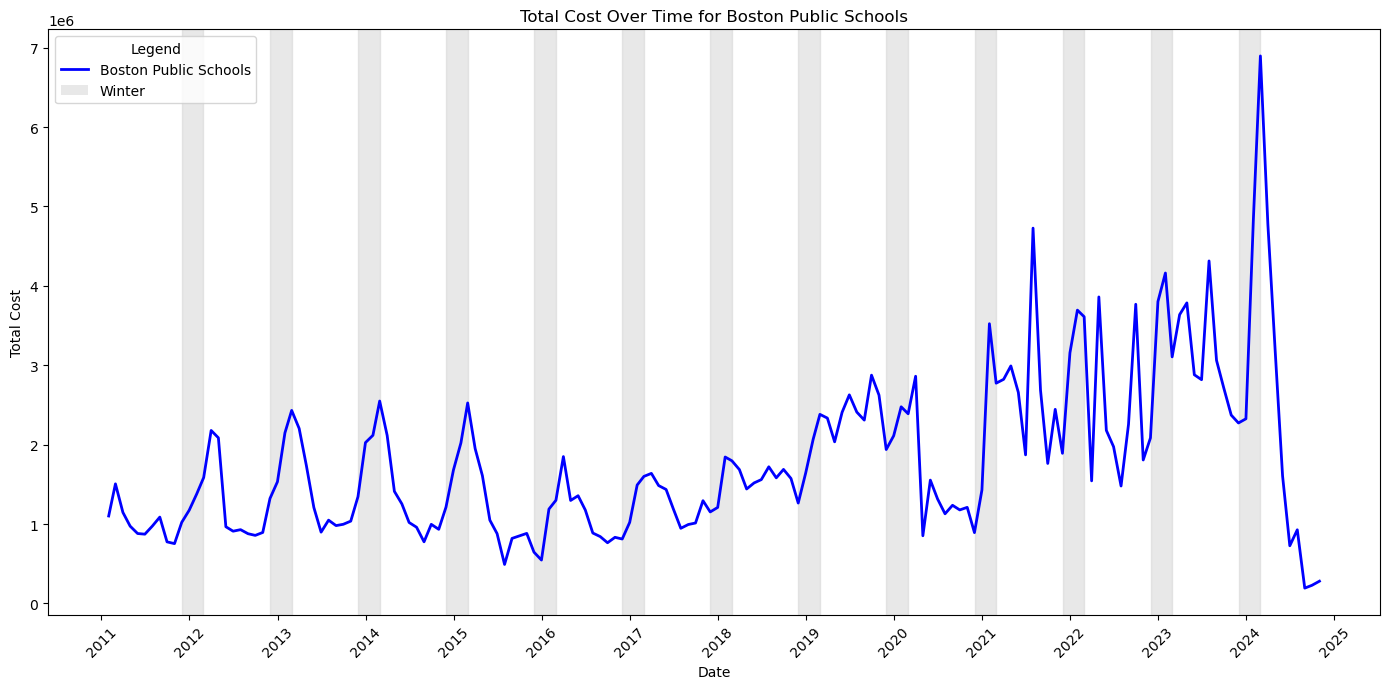

In [120]:
plot_department_total_cost(df_pivot, department_name='Boston Public Schools')

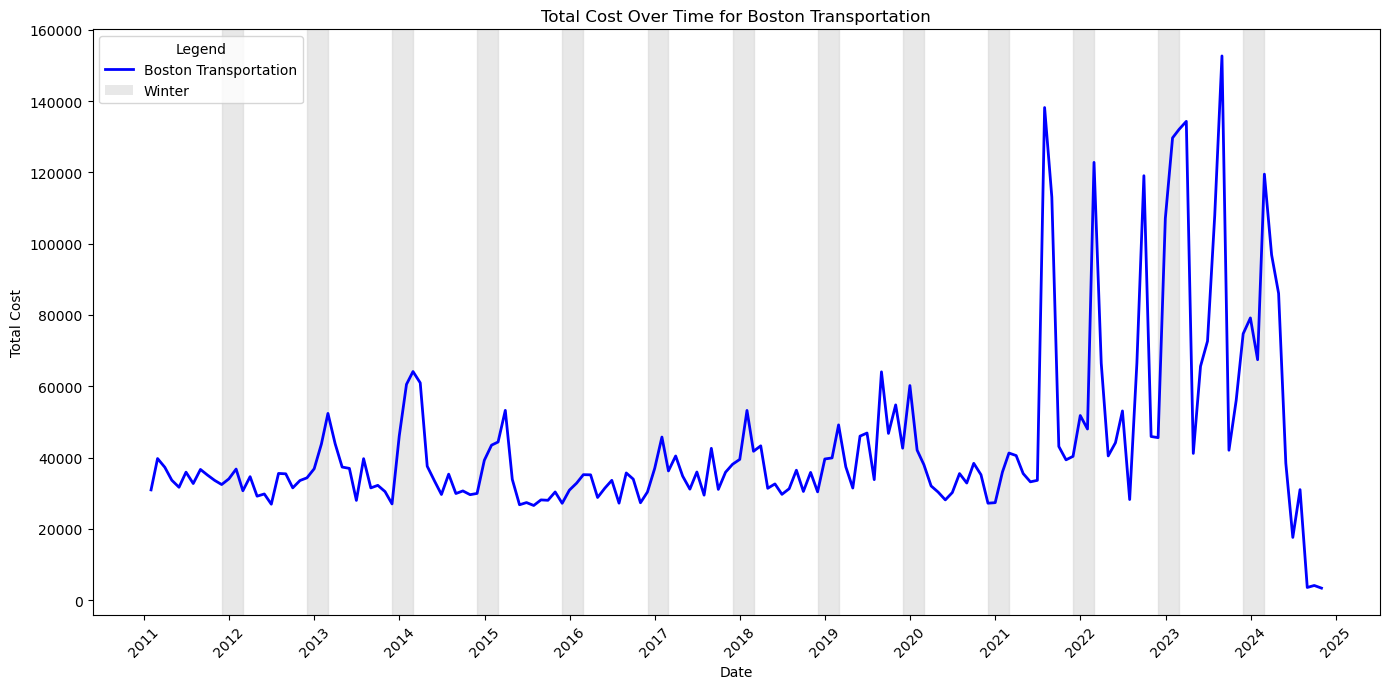

In [121]:
plot_department_total_cost(df_pivot, department_name='Boston Transportation')

In [158]:
def plot_department_energy_pie_chart(df, department_name):
    """
    Plots a pie chart showing the percentage distribution of EnergyTypeName 
    based on the number of observations for a specific DepartmentName.
    Labels and percentages are only displayed for slices >= 1%.
    
    Parameters:
    - df (pd.DataFrame): The raw DataFrame containing at least 'DepartmentName' and 'EnergyTypeName' columns.
    - department_name (str): The name of the department to plot.
    
    Returns:
    - None: Displays the pie chart.
    """
    # ------------------ Data Validation ------------------
    
    # Check if required columns exist
    required_columns = ['DepartmentName', 'EnergyTypeName']
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise ValueError(f"The following required columns are missing from the DataFrame: {missing_columns}")
    
    # Check if the specified department exists
    if department_name not in df['DepartmentName'].unique():
        raise ValueError(f"Department '{department_name}' not found in the DataFrame.")
    
    # ------------------ Data Aggregation ------------------
    
    dept_data = df[df['DepartmentName'] == department_name]
    
    if dept_data.empty:
        raise ValueError(f"No data available for Department '{department_name}'.")
    
    # Count the number of observations per EnergyTypeName
    energy_distribution = dept_data['EnergyTypeName'].value_counts()
    
    # Handle cases where there are no observations
    if energy_distribution.empty:
        raise ValueError(f"No EnergyTypeName data available for Department '{department_name}'. Cannot plot pie chart.")
    
    # Calculate percentages
    total = energy_distribution.sum()
    percentages = (energy_distribution / total) * 100
    
    # Define colors using a colormap
    colors = plt.cm.Paired(range(len(energy_distribution)))
    
    # Define a function for autopct to conditionally display percentages
    def autopct_func(pct):
        return f'{pct:.1f}%' if pct >= 1 else ''
    
    # Prepare labels: show label only if percentage >=1%
    labels = [label if pct >= 1 else '' for label, pct in zip(energy_distribution.index, percentages)]
    
    # Initialize the plot
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Plot the pie chart
    wedges, texts, autotexts = ax.pie(
        energy_distribution, 
        labels=labels, 
        autopct=autopct_func, 
        startangle=140,
        colors=colors,
        textprops={'fontsize': 12}
    )
    
    # Style the autotexts (percentages)
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
    
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    
    # Set title
    plt.title(f'Energy Type Distribution for {department_name}', fontsize=16)
    
    # Optional: Add a legend (useful if there are many energy types)
    from matplotlib.patches import Patch
    legend_handles = [Patch(facecolor=colors[i], label=energy) for i, energy in enumerate(energy_distribution.index)]
    ax.legend(handles=legend_handles, title='Energy Types', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to make room for the legend if it's used
    plt.tight_layout()
    
    # Display the plot
    plt.show()


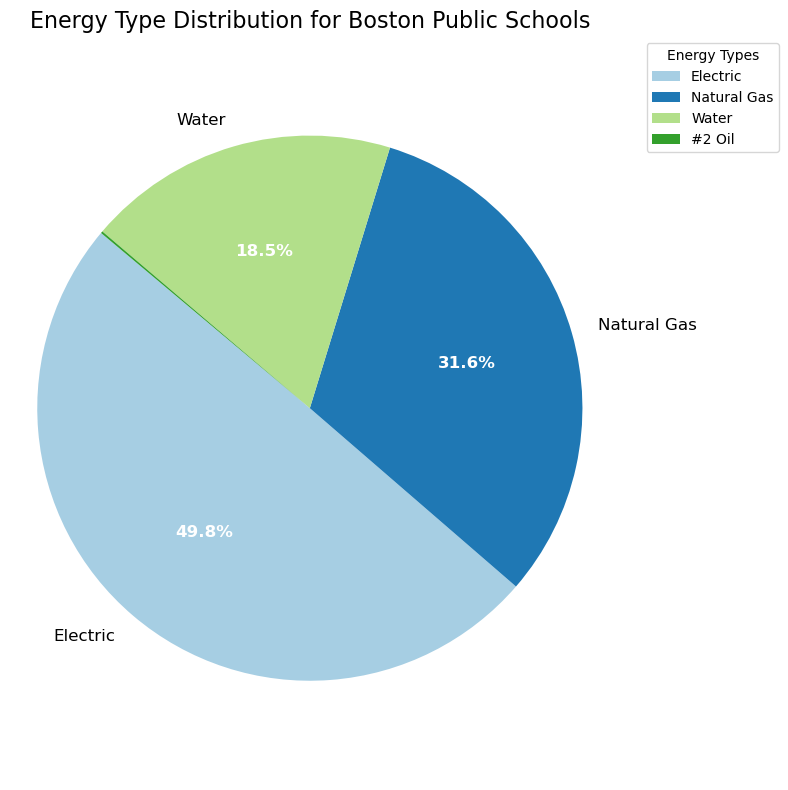

In [159]:
plot_department_energy_pie_chart(df, 'Boston Public Schools')

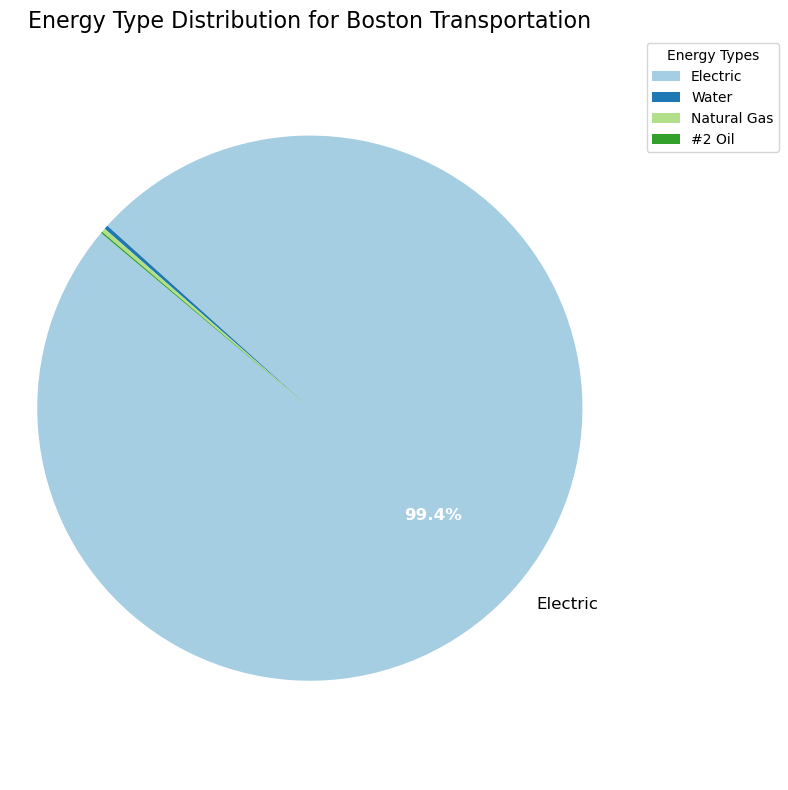

In [160]:
plot_department_energy_pie_chart(df, 'Boston Transportation')

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

def prepare_percentage_data(df):
    """
    Prepares the data by calculating the percentage distribution of energy type invoices per year.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing at least 'InvoiceDate' and 'EnergyType' columns.
    
    Returns:
    - pivot_df (pd.DataFrame): Pivoted DataFrame with years as index and energy types as columns containing percentage values.
    """
    # Ensure 'InvoiceDate' is in datetime format
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
    
    # Extract year from 'InvoiceDate'
    df['Year'] = df['InvoiceDate'].dt.year
    
    # Group by 'Year' and 'EnergyType' and count the number of invoices
    counts = df.groupby(['Year', 'EnergyTypeName']).size().reset_index(name='Count')
    
    # Calculate total invoices per year
    counts['Total'] = counts.groupby('Year')['Count'].transform('sum')
    
    # Calculate percentage
    counts['Percentage'] = (counts['Count'] / counts['Total']) * 100
    
    # Pivot the DataFrame to have years as rows and energy types as columns
    pivot_df = counts.pivot(index='Year', columns='EnergyTypeName', values='Percentage').fillna(0)
    
    # Sort the DataFrame by Year
    pivot_df = pivot_df.sort_index()
    
    return pivot_df

def plot_stacked_bar_chart(pivot_df):
    """
    Plots a stacked bar chart showing the percentage distribution of Energy Types for each year.
    Labels are positioned in the middle of each segment and only displayed if the segment is >=5%.
    
    Parameters:
    - pivot_df (pd.DataFrame): Pivoted DataFrame with years as index and energy types as columns containing percentage values.
    
    Returns:
    - None: Displays the stacked bar chart.
    """
    # Define the plot size
    plt.figure(figsize=(14, 8))
    
    # List of energy types
    energy_types = pivot_df.columns.tolist()
    
    # Colors: Generate a color palette (Set3 has up to 12 distinct colors; adjust if more energy types exist)
    colors = plt.cm.Set3(range(len(energy_types)))
    
    # Initialize the bottom for stacking
    bottom = [0] * len(pivot_df)
    
    # Plot each energy type
    for i, energy in enumerate(energy_types):
        plt.bar(
            pivot_df.index, 
            pivot_df[energy], 
            bottom=bottom, 
            label=energy, 
            color=colors[i]
        )
        
        # Calculate label positions
        for idx, (year, pct) in enumerate(zip(pivot_df.index, pivot_df[energy])):
            if pct >= 5:  # Only label segments with percentage >=5%
                # Calculate the position: bottom + half of the current segment
                label_position = bottom[idx] + pct / 2
                plt.text(
                    year, 
                    label_position, 
                    f'{pct:.1f}%', 
                    ha='center', 
                    va='center',
                    fontsize=10,
                    color='black'
                )
        
        # Update the bottom for the next energy type
        bottom = [bottom[j] + pivot_df[energy].iloc[j] for j in range(len(bottom))]
    
    # Set labels and title
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Percentage of Invoices (%)', fontsize=14)
    plt.title('Year-over-Year Distribution of Energy Type Invoices', fontsize=16)
    
    # Set x-axis ticks to be integer years
    plt.xticks(pivot_df.index, pivot_df.index, fontsize=12)
    
    # Add legend
    plt.legend(title='Energy Type', fontsize=12, title_fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Set y-axis limit to 100%
    plt.ylim(0, 100)
    
    # Improve layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

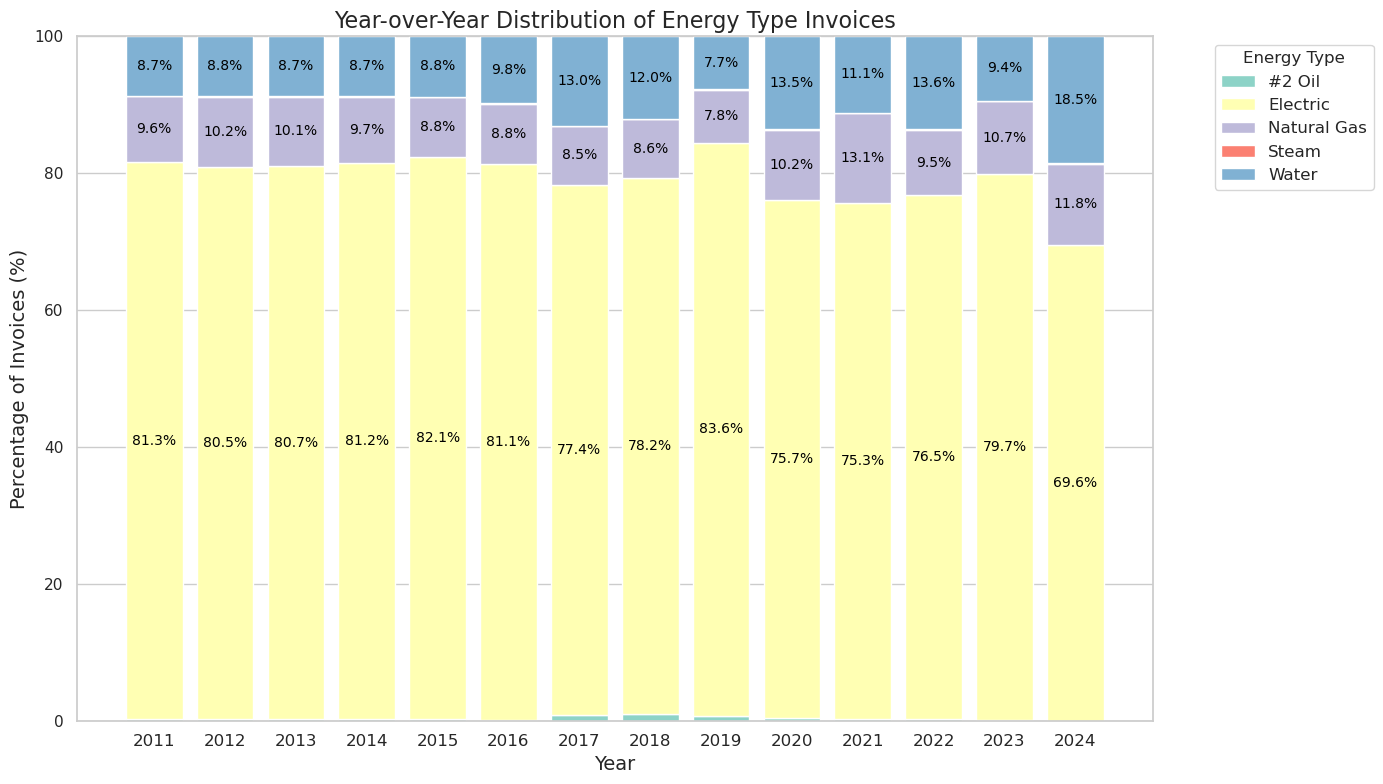

In [175]:
pivot_df = prepare_percentage_data(df)
plot_stacked_bar_chart(pivot_df)